In [ ]:
import os
import sys
from collections import Counter

import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchinfo
import torchvision
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from tqdm.version import __version__ as tqdm__version__

In [7]:
# !gcloud storage cp gs://wqu-cv-course-datasets/project1.tar.gz . #First we download the data i am using worldquant university public dataset

In [ ]:
# !tar --skip-old-files -xzf project1.tar.gz #Unzipping the downloaded file

In [9]:
train_path = os.path.join("data_p1","data_binary","train")
content = os.listdir(train_path)


In [10]:
dist_dict = {}
for con in content:
  dir = os.path.join(train_path,con)
  files = os.listdir(dir)
  num_files = len(files)
  dist_dict[con] = num_files
dist_dict

{'blank': 2213, 'hog': 978}

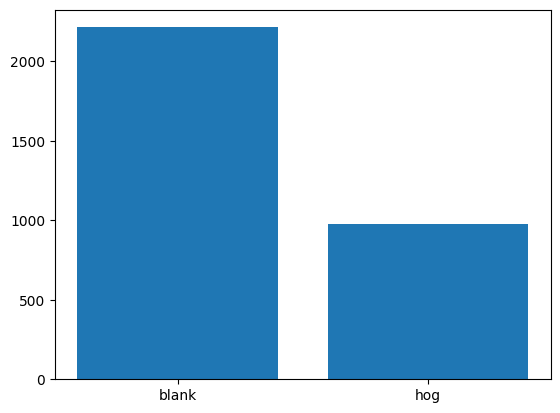

In [11]:
plt.bar(dist_dict.keys(),dist_dict.values())
plt.show()

In [ ]:
show_image = os.path.join(train_path,"hog","ZJ000005.jpg")
show_img_h = Image.open(show_image)
show_img_h

In [ ]:
show_image_b = Image.open("/content/data_p1/data_binary/train/blank/ZJ000013.jpg")
show_image_b

In [17]:
class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [19]:
transform = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])

    ]
)

In [20]:
dataset = datasets.ImageFolder(train_path, transform=transform)

In [22]:
g = torch.Generator()
g.manual_seed(42)

train_dataset, val_dataset = random_split(dataset, [0.8, 0.2], generator=g)

In [28]:
print(f"Length of training set: {len(train_dataset)}")
print(f"Length of validation set: {len(val_dataset)}")

Length of training set: 2553
Length of validation set: 638


In [29]:
def class_counts(dataset):
    c = Counter(x[1] for x in tqdm(dataset))
    class_to_index = dataset.dataset.class_to_idx
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})
train_counts = class_counts(train_dataset)
train_counts

  0%|          | 0/2553 [00:00<?, ?it/s]

,0
blank,1749
hog,804


In [30]:
val_counts = class_counts(val_dataset)
val_counts

  0%|          | 0/638 [00:00<?, ?it/s]

,0
blank,464
hog,174


In [32]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True, generator=g)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle=False, generator=g)

In [34]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(images.shape)
print(labels.shape)
labels

torch.Size([32, 3, 224, 224])
torch.Size([32])


tensor([0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 1, 1, 0, 0, 0, 0, 0])

In [35]:
flatten = nn.Flatten()
tensor_flatten = flatten(images)

In [37]:
height = 224
width = 224

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3*height*width, 512),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.ReLU(),
)
output_layer = nn.Linear(128,2)
model.append(output_layer)
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=150528, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=2, bias=True)
)


In [39]:
model.to("cuda")
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=150528, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=2, bias=True)
)

In [40]:
summary(model, input_size=(32, 3, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 2]                   --
├─Flatten: 1-1                           [32, 150528]              --
├─Linear: 1-2                            [32, 512]                 77,070,848
├─ReLU: 1-3                              [32, 512]                 --
├─Linear: 1-4                            [32, 128]                 65,664
├─ReLU: 1-5                              [32, 128]                 --
├─Linear: 1-6                            [32, 2]                   258
Total params: 77,136,770
Trainable params: 77,136,770
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 2.47
Input size (MB): 19.27
Forward/backward pass size (MB): 0.16
Params size (MB): 308.55
Estimated Total Size (MB): 327.98

In [41]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train_epoch(model, optimizer, loss_fn, data_loader, device="cuda"):

    training_loss = 0.0

    model.train()


    for inputs, targets in tqdm(data_loader, desc="Training", leave=False):

        optimizer.zero_grad()

        inputs = inputs.to(device)
        targets = targets.to(device)

        output = model(inputs)
        loss = loss_fn(output, targets)


        loss.backward()
        optimizer.step()


        training_loss += loss.data.item() * inputs.size(0)

    # We calculate the training loss over the completed epoch
    return training_loss / len(data_loader.dataset)

In [46]:
loss_value = train_epoch(model, optimizer, loss_fn, train_loader, device="cuda")
print(f"The average loss during the training epoch was {loss_value:.2f}.")

Training:   0%|          | 0/80 [00:00<?, ?it/s]

The average loss during the training epoch was 6.94.


In [49]:
loss_value = train_epoch(model, optimizer, loss_fn, train_loader, device="cuda")
print(f"The average loss during the training epoch was {loss_value:.2f}.")

Training:   0%|          | 0/80 [00:00<?, ?it/s]

The average loss during the training epoch was 1.96.


In [ ]:
def predict(model, data_loader, device="cuda"):

    all_probs = torch.tensor([]).to(device)

    model.eval()

    with torch.no_grad():

        for inputs, targets in tqdm(data_loader, desc="Predicting", leave=False):
            inputs = inputs.to(device)
            output = model(inputs)

            probs = F.softmax(output, dim=1)
            all_probs = torch.cat((all_probs, probs), dim=0)

    return all_probs

In [52]:
probabilities_train = predict(model, train_loader, device="cuda")
print(probabilities_train.shape)

Predicting:   0%|          | 0/80 [00:00<?, ?it/s]

torch.Size([2553, 2])


In [54]:
probabilities_val = predict(model, val_loader, device="cuda")
print(probabilities_val.shape)

Predicting:   0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([638, 2])


In [55]:
print(probabilities_train[0])
probabilities_val[0]

tensor([0.9596, 0.0404], device='cuda:0')


tensor([0.9974, 0.0026], device='cuda:0')

In [56]:
predictions_train = torch.argmax(probabilities_train, dim=1)

print(f"Predictions shape: {predictions_train.shape}")
print(f"First 10 predictions: {predictions_train[:10]}")

Predictions shape: torch.Size([2553])
First 10 predictions: tensor([0, 1, 0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')


In [59]:
predictions_val = torch.argmax(probabilities_val, dim=1)

print(f"Predictions shape: {predictions_val.shape}")
print(f"First 10 predictions: {predictions_val[:10]}")

Predictions shape: torch.Size([638])
First 10 predictions: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


In [61]:
device = "cuda"
targets_train = torch.cat([labels for _, labels in train_loader]).to(device)
is_correct_train = torch.eq(predictions_train, targets_train)
total_correct_train = torch.sum(is_correct_train).item()
accuracy_train = total_correct_train / len(train_loader.dataset)

print(f"Accuracy on the training data: {accuracy_train}")

Accuracy on the training data: 0.5934195064629847


In [62]:
targets_val = torch.cat([labels for _, labels in val_loader]).to(device)
is_correct_val = torch.eq(predictions_val, targets_val)
total_correct_val = torch.sum(is_correct_val).item()
accuracy_val = total_correct_val / len(val_loader.dataset)

print(f"Accuracy on the validation data: {accuracy_val}")

Accuracy on the validation data: 0.9106583072100314


In [ ]:
def score(model, data_loader, loss_fn, device="cuda"):

    total_loss = 0
    total_correct = 0

    model.eval()

 
    with torch.no_grad():

        for inputs, targets in tqdm(data_loader, desc="Scoring", leave=False):
            inputs = inputs.to(device)
            output = model(inputs)

   
            targets = targets.to(device)
            loss = loss_fn(output, targets)
            total_loss += loss.data.item() * inputs.size(0)

            correct = torch.eq(torch.argmax(output, dim=1), targets)
            total_correct += torch.sum(correct).item()

    return total_loss / len(data_loader.dataset), total_correct / len(
        data_loader.dataset
    )

In [64]:
loss_train, accuracy_train = score(model, train_loader, loss_fn, device)
print(f"Training accuracy from score function: {accuracy_train}")

Scoring:   0%|          | 0/80 [00:00<?, ?it/s]

Training accuracy from score function: 0.8965922444183314


In [65]:
loss_val, accuracy_val = score(model, val_loader, loss_fn, device)
print(f"Validation accuracy from score function: {accuracy_val}")

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Validation accuracy from score function: 0.9106583072100314


In [ ]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):

    for epoch in range(1, epochs + 1):

        training_loss = train_epoch(model, optimizer, loss_fn, train_loader, device)


        validation_loss, validation_accuracy = score(model, val_loader, loss_fn, device)

        print(
            f"Epoch: {epoch}, Training Loss: {training_loss:.2f}, "
            f"Validation Loss: {validation_loss:.2f}, Validation Accuracy: {validation_accuracy:.2f}"
        )

In [67]:
train(model, optimizer, loss_fn, train_loader, val_loader, epochs=5, device=device)

Training:   0%|          | 0/80 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 0.51, Validation Loss: 0.40, Validation Accuracy: 0.84


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2, Training Loss: 0.32, Validation Loss: 0.26, Validation Accuracy: 0.93


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 3, Training Loss: 0.30, Validation Loss: 0.22, Validation Accuracy: 0.92


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 4, Training Loss: 0.16, Validation Loss: 0.16, Validation Accuracy: 0.95


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 5, Training Loss: 0.15, Validation Loss: 0.22, Validation Accuracy: 0.94


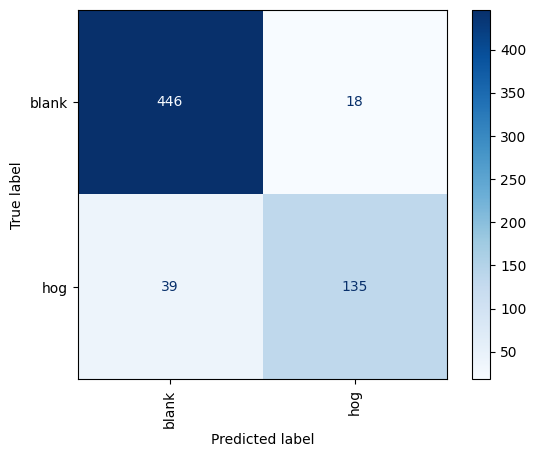

In [68]:
cm = confusion_matrix(targets_val.cpu(), predictions_val.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["blank", "hog"])

disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical");

In [72]:
os.makedirs("model", exist_ok=True)

torch.save(model, os.path.join("model", "shallownet"))